In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf,read_raw_fif
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.filter import construct_iir_filter,create_filter
from sklearn.model_selection import train_test_split
import torch
from scipy.signal import iirfilter, sosfiltfilt


In [7]:

def get_physio():
    subject =['01','02','03','04','05','06','07','08','09','10','11','12','13','14']
    path = "EEG_Model\\dataset\\physio\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0"
    folders = os.listdir(path)
    subject_count = 0
    train_path = []
    valid_path = []
    count = 0
    for fol in folders:
        if count == 10:
            break
        else:
            count +=1
        for i in range (len (subject)):
            if  subject[i] in ['01','02','05','06','09','10','13','14']:
                pass
            elif subject[i] in ['03','04','07','08']:
                file = "EEG_Model\\dataset\\physio\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\{}\\{}R{}.edf".format(fol,fol, subject[i])
                train_path.append(file)
            elif subject[i] in ['11','12']:
                file = "EEG_Model\\dataset\\physio\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\{}\\{}R{}.edf".format(fol,fol, subject[i])
                valid_path.append(file)
            
  
    return valid_path,train_path

def get_epoch(data_path,tmin,tmax,event_id,preprocess=False,ica=False):
    
    raw = concatenate_raws([read_raw_edf(f, preload=True,verbose='WARNING') for f in data_path])
    raw_data = raw.copy()
    eegbci.standardize(raw_data)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw_data.set_montage(montage)
    print(raw_data.info['ch_names'])
    raw_data.rename_channels(lambda x: x.strip('.'))
    print(raw_data.info['ch_names'])
    print(raw_data.info['sfreq'])
    
    sfreq = 641
    nyq = sfreq / 2 
    f_p = 40.
    
    # Apply band-pass filter
    if preprocess == True:
        iir_param = dict(order=6, ftype='butter', output='sos')
        #iir_param = construct_iir_filter(iir_param, 40, None, 1000, 'low', return_copy=False) 
         
        #raw_data.filter(l_freq=0.05, h_freq=40.,fir_design='firwin', verbose=20)
        raw_data.filter(l_freq=0.05, h_freq=75.,method = 'iir',iir_params=iir_param,phase='zero')
        #raw_data.notch_filter(60,filter_length='auto', phase='zero')
        raw_data.notch_filter(50,filter_length='auto', phase='zero')
        
    if ica == True:
        ica = mne.preprocessing.ICA(n_components=64, max_iter=100)
        ica.fit(raw_data)
        ica.exclude = [1, 2]  # details on how we picked these are omitted here
        ica.plot_properties(raw_data, picks=ica.exclude)
        ica.apply(raw_data)
    #2 electrode        
    #raw_data.pick_channels(['C3','C4'])
    #16 electrode
    #raw_data.pick_channels(['FC3','FCz','FC5','C1','C2','C3','C4','C5','C6','Cz','CP3','CPz','CP4','P3','Pz','P4'])
    events, event_id = events_from_annotations(raw_data,event_id=event_id)
    picks = pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    reject_criteria = dict(eeg=100e-6)  #most frequency in this range is not brain components
    
    epochs = Epochs(raw_data, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None,preload=True)
    labels = epochs.events[:, -1]
    return epochs.get_data(),labels,epochs,raw_data
    
def get_data():
    valid_path, train_path = get_physio()
        
    #tmin, tmax = -0.2, 0.4
    tmin, tmax = 0, 4
    event_id = dict(T1=0, T2=1)

    train_epoch,train_labels,raw_epoch,raw = get_epoch(train_path,tmin,tmax,event_id,False)
    valid_epoch,valid_labels,_,_ = get_epoch(valid_path,tmin,tmax,event_id,False)
    
    return train_epoch,train_labels,valid_epoch,valid_labels,raw_epoch,raw

#train_epoch,valid_epoch,train_labels,valid_labels,raw_epoch,raw= get_data()
train_epoch,train_labels,valid_epoch,valid_labels,raw_epoch,raw= get_data()

FileNotFoundError: [Errno 2] No such file or directory: '.\\dataset\\physio\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0'

In [3]:
# 100068 events(epoch)
# 64 channel
# 961 Time(samples)
#(event,channel,time)
print(train_epoch.shape)
print(train_labels.shape)
print('---------------')
#print(valid_epoch.shape)
#print(valid_labels.shape)
X = train_epoch[:, np.newaxis,:,:]
y = train_labels
print(X.shape)
print(train_epoch.shape[1])
print(train_labels)
print(raw.info['ch_names'])
print(raw.info['nchan'])

(600, 64, 641)
(600,)
---------------
(600, 1, 64, 641)
64
[1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1
 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1
 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0
 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1
 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0
 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 1
 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0
 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0
 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1
 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1
 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1
 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 

In [4]:
'''import pickle
valid , train = get_physio()
filename = 'validpath'
outfile = open(filename,'wb')
pickle.dump(valid,outfile)
outfile.close()
infile = open(filename,'rb')
new = pickle.load(infile)'''


"import pickle\nvalid , train = get_physio()\nfilename = 'validpath'\noutfile = open(filename,'wb')\npickle.dump(valid,outfile)\noutfile.close()\ninfile = open(filename,'rb')\nnew = pickle.load(infile)"

In [5]:
#10614 data,64 channel,161 timesamples

X_t,y_train= train_epoch.copy(),train_labels

X_val,y_valid = valid_epoch.copy(),valid_labels

'''X = X[:, np.newaxis,:,:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)'''

#add new dimension
X_train = X_t[:, np.newaxis,:,:]
X_valid = X_val[:,np.newaxis,:,:]

'''
X_train = X_t[:,:,:]
X_valid = X_val[:,:,:]
'''
#X_valid = X_valid[:,np.newaxis,:,:]
print(X_train.shape)
print(y_train.shape)
print(type(X_train))
print(type(y_train))



(600, 1, 64, 641)
(600,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
import torch   
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import Subset  
from torch import nn  
import torch.nn.functional as F  
from torch.utils.data import TensorDataset


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.temporal= nn.Conv1d(in_channels=2,out_channels=25,kernel_size=1,stride=1,padding=1)
        
        self.spatial = nn.Conv1d(in_channels=25,out_channels=25,kernel_size=25,stride=1,padding=1)
        self.batchnorm1 = nn.BatchNorm1d(25,False)
        self.maxPooling = nn.MaxPool1d(3)
        
        self.conv3 = nn.Conv1d(in_channels=25,out_channels=50,kernel_size=11,stride=1,padding=1)
        self.conv4 = nn.Conv1d(in_channels=50,out_channels=100,kernel_size=11,stride=1,padding=1)
        self.batchnorm2 = nn.BatchNorm1d(100,False)
        
        self.conv5 = nn.Conv1d(in_channels=100,out_channels=200,kernel_size=11,stride=1,padding=1)
        self.batchnorm3 = nn.BatchNorm1d(200,False)
        self.maxPooling2 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fully = nn.Linear(1000,2) 
        
    def forward(self,x):
        #print(x.shape)
        x = self.temporal(x)
        #print('Temporal: '+str(x.shape))
        x = F.leaky_relu(x)
        x = F.dropout(x,0.5)
        #print('Dropout: '+str(x.shape))
        
        x = self.spatial(x)
        #print('Spatial: '+str(x.shape))
        x = self.batchnorm1(x)
        #print('Batchnorm: '+str(x.shape))
        x = F.leaky_relu(x)
        x = self.maxPooling(x)
        #print('Max pooling: '+str(x.shape))
        
        x = self.conv3(x)
        #print('Convo3 : '+str(x.shape))
        x = F.leaky_relu(x)
        x = F.dropout(x,0.5)
        x = self.maxPooling(x)
        #rint('Max pooling : '+str(x.shape))
        
        x = self.conv4(x)
        #print('Convo4 : '+str(x.shape))
        x = self.batchnorm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x,0.5)
        #print('Dropout: '+str(x.shape))
        x = self.maxPooling(x)
        #print('Max pooling : '+str(x.shape))
        
        x = self.conv5(x)
        #print('Convo5 : '+str(x.shape))
        x = self.batchnorm3(x)
        x = F.leaky_relu(x)
        x = self.maxPooling2(x)
        #print('Max pooling 2 : '+str(x.shape))
        x = self.flatten(x)
        #print('Flatten : '+str(x.shape))
        out = self.fully(x)
        return out

In [8]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #in_channel = 1
            #out_channel = 16
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        #nn.MaxPool2d(kernel_size=2, stride=2)
        #after layer 1 will be of shape [32, 16, 32, 80]
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        #add
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        
        #nn.MaxPool2d(kernel_size=1, stride=2)
        #after layer 2 will be of shape [100, 32, 16, 40]
        #20480   40960
        self.fc = nn.Linear(327680, 2)
        self.drop_out = nn.Dropout(0.5)  #zeroed 0.2% data
        #after fc will be of shape [100, 10]
        
    def forward(self, x):
        #x shape: [batch, in_channel, img_width, img_height]
        #[32, 1, 64, 161]
        out = self.layer1(x)
        #print(out.shape)
        out = self.drop_out(out)
        #after layer 1: shape: [32, 16, 32, 80]
        out = self.layer2(out)
        #print(out.shape)
        out = self.drop_out(out)
        #after layer 2: shape: [100, 32, 16, 40]
        out = out.reshape(out.size(0), -1)   #can also use .view()
        #after squeezing: shape: [32, 20480]
        #print(out.shape)
        #we squeeze so that it can be inputted into the fc layer
        out = self.fc(out)
        #after fc layer: shape: [32, 2]
        return out

In [9]:
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.layer1 = nn.Sequential(
            #in_channel = 1
            #out_channel = 25
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv2d(1,25,kernel_size = 3,stride = 1, padding = 1),
            nn.LeakyReLU(),
            nn.Dropout2d(0.5)  
            )
        self.layer2 = nn.Sequential(
            #in_channel = 1
            #out_channel = 16
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv2d(25,25,kernel_size = 4, stride = 1, padding = 1),
            nn.BatchNorm2d(25,False),
            nn.LeakyReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(25,50,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(0.5)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(50,100,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(100,False),
            nn.LeakyReLU(),
            nn.Dropout2d(0.5)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(100,200,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(200,False),
            nn.LeakyReLU(),
            nn.Dropout2d(0.5)
        )
        
        self.fully = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2400,2)
        )
        
        self.maxpooling1 = nn.MaxPool2d(kernel_size=1,stride = 3)
        self.maxpooling2 = nn.MaxPool2d(kernel_size=1,stride = 2)
        
    def forward(self,x):
        out = self.layer1(x)
        #print("layer1: " + str(out.shape))
        out = self.layer2(out)
        #print("layer2: " + str(out.shape))
        out = self.maxpooling1(out)
        #print("Maxpooling: " + str(out.shape))
        out = self.layer3(out)
        #print("layer3: " + str(out.shape))
        out = self.maxpooling1(out)
        #print("Maxpooling: " + str(out.shape))
        out = self.layer4(out)
        #print("layer4: " + str(out.shape))
        out = self.maxpooling1(out)
        #print("Maxpooling: " + str(out.shape))
        out = self.layer5(out)
        #print("layer5: " + str(out.shape))
        out = self.maxpooling2(out)
        #print("Maxpooling: " + str(out.shape))
        out = self.fully(out)
        #print(out.shape)
        return out

In [10]:
#use 1d convolution and 2d input (channel,timewindow)
class hopefullnet(nn.Module):
    def __init__(self):
        super(hopefullnet,self).__init__()
        
        self.L1 = nn.Sequential(
            #in_channel = 2
            #out_channel or Filter size = 32
            #kernel size = 20
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv1d(2,32, kernel_size = 20, stride = 1 , padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )
        self.L2 = nn.Sequential(
            #in_channel = 32
            #out_channel or Filter size = 32
            #kernel_size =20
            #stride = 1
            #padding = valid
            #Relu
            nn.Conv1d(32,32,kernel_size=20,stride = 1, padding = 'valid'),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )
        self.L3 = nn.Conv1d(32,32,kernel_size=6,stride = 1, padding='valid')
        self.pooling = nn.AvgPool1d(kernel_size=2,stride = 2)
        self.L4 = nn.Sequential(
            #in_channel = 32
            #out_channel = 32
            #kernel_size = 6
            #stride = 1
            #padding = 'valid'
            #relu
            nn.Conv1d(32,32,kernel_size = 6, stride = 1 , padding = 'valid'),
        )
        
        self.fully = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(nn.Linear(9696,2)),
            nn.Dropout(0.5),
            nn.ReLU(nn.Linear(296,148)),
            nn.Dropout(0.5),
            nn.ReLU(nn.Linear(148,74)),
            nn.Dropout(0.5),
            nn.Linear(74,2)
        )
        self.fully1 = nn.Linear(9696,296)
        self.fully2 = nn.Linear(296,148)
        self.fully3 = nn.Linear(148,74)
        self.fully4 = nn.Linear(74,2)
        self.flatten = nn.Flatten()
        self.drop_out = nn.Dropout(0.5)
    def forward(self,x):
        
        out = self.L1(x)
        out = self.L2(out)
        out = self.drop_out(out)
        out = self.L3(out)
        out = self.pooling(out)
        out = self.L4(out)
        out = self.drop_out(out)
        out = self.flatten(out)
        
        out = F.relu(self.fully1(out))
        out = self.drop_out(out)
        out = F.relu(self.fully2(out))
        out = self.drop_out(out)
        out = F.relu(self.fully3(out))
        out = self.drop_out(out)
        out = F.softmax(self.fully4(out))
        #out = self.fully(out)
        
        return out

In [11]:
#use 2d convolution and 3d input (1,channel,timewindow)
class gamenet(nn.Module):
    def __init__(self):
        super(gamenet,self).__init__()
        
        self.l1 = nn.Sequential(
            #in_channel = 16
            #out_channel or Filter size = 100
            #kernel size = (1,25)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(1,100,kernel_size=(1,25),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l2 = nn.Sequential(
            #in_channel = 100
            #out_channel or Filter size = 100
            #kernel size = (16,1)
            #stride = 1
            #padding = Valid
            #Relu
            #nn.Conv2d(100,100,kernel_size=(16,1),stride=1,padding='valid')
            nn.Conv2d(100,100,kernel_size=(64,1),stride=1,padding='valid'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l3 = nn.Sequential(
            #in_channel = 100
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(100,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling1 = nn.MaxPool2d(kernel_size=(1,7),stride=5)
        self.l4 = nn.Sequential(
            #in_channel = 50
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(50,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling2 = nn.MaxPool2d(kernel_size=(1,3),stride=2)
        

        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(3150),
            nn.Dropout(0.15)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(3150,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.15)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.15)
        )
        self.fc5 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15)
        )
        self.fc6 = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.15)
        )
        self.softmax = nn.Sequential(
            nn.Linear(32,2),
            nn.Softmax()
        )
    def forward(self,x):
        
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.maxpooling1(out)
        out = self.l4(out)
        out = self.maxpooling2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        out = self.softmax(out)
        return out
        
        

In [12]:
import math
batch_size = 32
def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl

train_iterator = create_dataloader(X_train, y_train, batch_size=batch_size)
valid_iterator = create_dataloader(X_valid, y_valid, batch_size=batch_size)

num_step =math.ceil(len(train_iterator.dataset) / batch_size)


In [13]:
from torchsummary import summary
device = 'cuda'
#model = CNN()
#model = CNN2D()
#model = ConvNet()
#model = hopefullnet()
model = gamenet()
#print(model)

#summary(model.cuda(), ( 2 , 641),32)
summary(model.cuda(), ( 1,64, 641),32)



C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\modules\conv.py:439: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:660.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 100, 64, 641]           2,600
              ReLU-2         [32, 100, 64, 641]               0
       BatchNorm2d-3         [32, 100, 64, 641]             200
            Conv2d-4          [32, 100, 1, 641]         640,100
              ReLU-5          [32, 100, 1, 641]               0
       BatchNorm2d-6          [32, 100, 1, 641]             200
            Conv2d-7           [32, 50, 1, 641]         150,050
              ReLU-8           [32, 50, 1, 641]               0
       BatchNorm2d-9           [32, 50, 1, 641]             100
        MaxPool2d-10           [32, 50, 1, 127]               0
           Conv2d-11           [32, 50, 1, 127]          75,050
             ReLU-12           [32, 50, 1, 127]               0
      BatchNorm2d-13           [32, 50, 1, 127]             100
        MaxPool2d-14            [32, 50

C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [14]:
'''for i, (x,y) in enumerate(train_iterator):
    x = x.to(device=device,dtype=torch.float32)
    model.to(device=device) 
    print(x.shape)
    model(x)
    
    break'''

'for i, (x,y) in enumerate(train_iterator):\n    x = x.to(device=device,dtype=torch.float32)\n    model.to(device=device) \n    print(x.shape)\n    model(x)\n    \n    break'

In [15]:
'''X_torch = torch.from_numpy(X_train).double()
y_torch = torch.from_numpy(y_train).long()
train_set = TensorDataset(X_torch, y_torch)
#valid_set = TensorDataset(torch.from_numpy(X_valid).double(),torch.from_numpy(y_valid).long())

BATCH_SIZE = 32
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
'''

'X_torch = torch.from_numpy(X_train).double()\ny_torch = torch.from_numpy(y_train).long()\ntrain_set = TensorDataset(X_torch, y_torch)\n#valid_set = TensorDataset(torch.from_numpy(X_valid).double(),torch.from_numpy(y_valid).long())\n\nBATCH_SIZE = 32\ntrain_iterator = torch.utils.data.DataLoader(dataset=train_set, \n                                           batch_size=BATCH_SIZE, \n                                           shuffle=True)\n\nvalid_iterator = torch.utils.data.DataLoader(dataset=valid_set, \n                                           batch_size=BATCH_SIZE, \n                                           shuffle=True)\n'

In [16]:
import wandb
wandb.login()
wand = wandb.init(
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"Gamenet_64Elec_executedImagine_Wandb", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.00001,
      "architecture": "GameNet",
      "dataset": "Physionet",
      "epochs": 500,
      "weightname":"Physionet_Gamenet_64elec_executedImagine_Wandb",
      "num_step_per_epoch" : num_step, 
      }
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: newturno (use `wandb login --relogin` to force relogin)
C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [17]:
config = wand.config
print(config.num_step_per_epoch)

19


In [18]:
# Train
from common import train

lr = 0.00001
n_epochs = 2000
patience = 200
#,weight_decay=1e-2
weight_name = "Physionet_hopefullnet_C3C4_executedImagine_Wandb"
model.to(device=device) 
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate,amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

best_model,train_loss,valid_loss,train_acc,valid_acc = train(model, train_iterator, valid_iterator, optimizer,criterion,device,wand)
wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )


Starting epoch 1 / 500


C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/500, Tr Loss: 0.7017, Tr Acc: 50.6667, Val Loss: 0.6979, Val Acc: 51.0000

Starting epoch 2 / 500
Epoch 2/500, Tr Loss: 0.7013, Tr Acc: 51.1667, Val Loss: 0.7115, Val Acc: 51.0000

Starting epoch 3 / 500
Epoch 3/500, Tr Loss: 0.7036, Tr Acc: 51.5000, Val Loss: 0.7141, Val Acc: 51.0000

Starting epoch 4 / 500
Epoch 4/500, Tr Loss: 0.7035, Tr Acc: 50.8333, Val Loss: 0.7153, Val Acc: 51.3333

Starting epoch 5 / 500
Epoch 5/500, Tr Loss: 0.7023, Tr Acc: 52.8333, Val Loss: 0.7032, Val Acc: 51.0000

Starting epoch 6 / 500
Epoch 6/500, Tr Loss: 0.6903, Tr Acc: 54.3333, Val Loss: 0.6974, Val Acc: 52.0000

Starting epoch 7 / 500
Epoch 7/500, Tr Loss: 0.6827, Tr Acc: 55.5000, Val Loss: 0.6911, Val Acc: 49.6667

Starting epoch 8 / 500
Epoch 8/500, Tr Loss: 0.6818, Tr Acc: 56.0000, Val Loss: 0.6872, Val Acc: 54.3333

Starting epoch 9 / 500
Epoch 9/500, Tr Loss: 0.6766, Tr Acc: 58.1667, Val Loss: 0.6855, Val Acc: 55.0000

Starting epoch 10 / 500
Epoch 10/500, Tr Loss: 0.6684, Tr Acc: 59.833

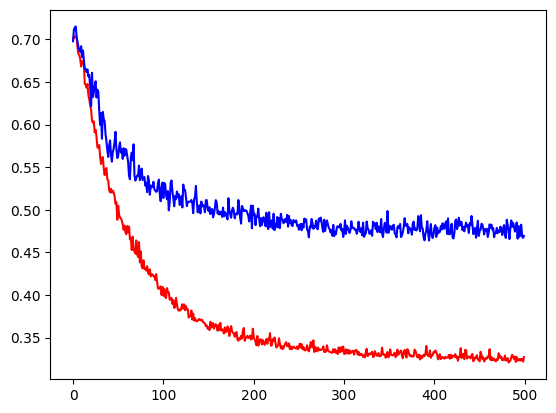

Train loss0.32075140664452
Valid loss0.4639082133769989


In [19]:
def do_plot(train_loss, valid_loss):
    plt.figure(figsize=(10,10))
    plt.plot(train_loss, label='train_loss')
    plt.plot(valid_loss, label='valid_loss')
    plt.title('loss {}'.format(iter))
    plt.legend()
    plt.show()

import matplotlib.pyplot as plt
plt.plot(train_loss,'r')
plt.plot(valid_loss,'b')
plt.show()
print("Train loss" + str(min(train_loss)))
print("Valid loss" + str(min(valid_loss)))

In [20]:
import math
print('Train acc: '+ str(train_acc[-1].item()))
print(max(train_acc).item())
print(sum(train_acc).item()/len(train_acc))

print('Valid acc:' + str(valid_acc[-1].item()))
print(max(valid_acc).item())
print(sum(valid_acc).item()/len(valid_acc))

Train acc: 99.66667175292969
100.0
96.0209453125
Valid acc:83.66666666666667
85.33333333333334
80.3906666666667


In [20]:
# 🐝 Close your wandb run 
wandb.finish()

train/train_loss,█████▇█▇▇▅▅▅▆▄▆▄▄▄▂▅▄▄▂▃▅▂▃▃▄▁▅▃▂▆▄▁▃▃▄▃
val/val_accuracy,▁▁▃▄▃▆▆▆▅▇▅▇▇▆▇▇▆▇▅▇▇▆█▇▇▅▇▇▇██▇██▇█████
val/val_loss,████▇▇▆▅▅▄▇▄▄▄▃▁▃▂▆▂▂▄▂▂▂▆▃▂▂▂▁▃▂▁▃▁▂▁▂▂
train/train_loss,0.37556
val/val_accuracy,76.33333
val/val_loss,0.55761
